# NOAA Hurricane and Tornado Intensity Prediction

Predict the maximum intensity of hurricane and tornado events. Use historical hurricane and tornado records from NOAA to find patterns to predict what the maximum intensity of these storm events may be. For the project, the primary research question is, 

"Given a storm event occuring in some area within the Contiguous United States , or on a path towards the Contiguous United States, what intensity will the storm event achieve?"


The data used for this analysis will be from the [NCDC Storm Events Database](https://catalog.data.gov/dataset/ncdc-storm-events-database). This data contains a master set of all storm events since 1950. This dataset is updated frequently, but at of this time of this analysis records up to and including June 2020 will be analyzed.

<hr>

## Table of Contents

1. [Initial Data Preparation](#data-prep)
2. [Database Creation and Data Import](#database)
3. [Exploratory Data Analysis](#eda)
4. [Focused Data Preparation](#focused-data-prep)

In [1]:
# Basic Utilities
import pandas as pd
import numpy as np
import glob

# Visualization 
import seaborn as sb
import matplotlib.pyplot as plt
import folium

# Database
from influxdb import DataFrameClient

# notebook properties
%matplotlib inline
pd.set_option('display.max_columns', 500)
sb.set(rc={'figure.figsize':(11,7)})

<a id='data-prep'></a>
## Initial Data Preparation
Process the raw NOAA data which is stored as a large directory of zipped CSVs. We need to decompress all of this data and get it prepared for injection into InfluxDB. InfluxDB will allow us to perform optimized time-based queries when necessary and subset the data if laptop memory is running scarce.

In [2]:
storm_data_files = glob.glob("../data/raw/StormEvents*.gz")
storm_data_files[:5]

['../data/raw\\StormEvents_details-ftp_v1.0_d1950_c20170120.csv.gz',
 '../data/raw\\StormEvents_details-ftp_v1.0_d1951_c20160223.csv.gz',
 '../data/raw\\StormEvents_details-ftp_v1.0_d1952_c20170619.csv.gz',
 '../data/raw\\StormEvents_details-ftp_v1.0_d1953_c20160223.csv.gz',
 '../data/raw\\StormEvents_details-ftp_v1.0_d1954_c20160223.csv.gz']

In [3]:
storm_data = pd.concat([pd.read_csv(x, compression='gzip') for x in storm_data_files])
storm_data.head()

C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (29,34,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Capture the rogue files that weren't compressed with gzip..
non_gzip_files = glob.glob("../data/raw/StormEvents*.csv")
non_gzip_files

['../data/raw\\StormEvents_locations-ftp_v1.0_d2000_c20200707.csv']

In [5]:
non_gzip_data = pd.concat([pd.read_csv(x) for x in non_gzip_files])
storm_data = pd.concat([storm_data, non_gzip_data])
storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Assessing Timeseries Missingness
Downselect all of the data to only the observations that at least have a timestamp. We need a timestamp since seasonal/monthly variation will be important to our analysis. Hurricanes and tornados occuring at different stages of the season may have different maximum intensities.

**Note 10/22:** After further digging into the NOAA database, a method to impute the missing timeseries data can not be found. It seems like the missing timestamps here will remain missing within the dataset. Since we need the timestamps, let's take a look at what percentage of our dataset would be removed due to missingness.

In [6]:
n_observations = len(storm_data.index)
n_missing_begin_timestamps = sum(storm_data['BEGIN_DATE_TIME'].isna())
n_missing_end_timestamps = sum(storm_data['END_DATE_TIME'].isna())

print("{} of {} rows have a missing start timestamp - {:.2f}% missingness"\
      .format(n_missing_begin_timestamps, n_observations, 100 * n_missing_begin_timestamps / n_observations))
print("{} of {} rows have a missing end timestamp - {:.2f}% missingness"\
      .format(n_missing_end_timestamps, n_observations, 100 * n_missing_end_timestamps / n_observations))

1398963 of 3032660 rows have a missing start timestamp - 46.13% missingness
1398963 of 3032660 rows have a missing end timestamp - 46.13% missingness


Almost half of our data experiences missingness in both the `BEGIN_DATE_TIME` timestamp andthe `END_DATE_TIME` timestamp. What is good about the equal missingness here is that we are at least consistent with the number of observations with a missing timestamp (upon further inspection, we do not see records where the start timestamp is missing but the end timestamp exists and vice-versa). Let's see if the old-fashioned timestamp (string-based entry of date-time) was used more frequently. This may be a case where the newer `DateTime` datatype wasn't implemented until a certain year or until a team of developers came in and upgraded the logging of storm events.

In [7]:
# Find the missingness for the year/month column
n_missing_begin_simple_yearmo = sum(storm_data['BEGIN_YEARMONTH'].isna())
n_missing_end_simple_yearmo = sum(storm_data['END_YEARMONTH'].isna())

# Missingnes for the day column
n_missing_begin_simple_day = sum(storm_data['BEGIN_DAY'].isna())
n_missing_end_simple_day = sum(storm_data['END_DAY'].isna())

# Missingness for the time column
n_missing_begin_simple_times = sum(storm_data['BEGIN_TIME'].isna())
n_missing_end_simple_times = sum(storm_data['END_TIME'].isna())

# Let's take a look at the percentage of missingness
print("{} of {} rows have a missing start year-month - {:.2f}% missingness"\
      .format(n_missing_begin_simple_yearmo, n_observations, 100 * n_missing_begin_simple_yearmo / n_observations))
print("{} of {} rows have a missing end year-month - {:.2f}% missingness"\
      .format(n_missing_end_simple_yearmo, n_observations, 100 * n_missing_end_simple_yearmo / n_observations))
print("{} of {} rows have a missing start year-month - {:.2f}% missingness"\
      .format(n_missing_begin_simple_day, n_observations, 100 * n_missing_begin_simple_day / n_observations))
print("{} of {} rows have a missing end year-month - {:.2f}% missingness"\
      .format(n_missing_end_simple_day, n_observations, 100 * n_missing_end_simple_day / n_observations))
print("{} of {} rows have a missing start year-month - {:.2f}% missingness"\
      .format(n_missing_begin_simple_times, n_observations, 100 * n_missing_begin_simple_times / n_observations))
print("{} of {} rows have a missing end year-month - {:.2f}% missingness"\
      .format(n_missing_end_simple_times, n_observations, 100 * n_missing_end_simple_times / n_observations))

1398963 of 3032660 rows have a missing start year-month - 46.13% missingness
1398963 of 3032660 rows have a missing end year-month - 46.13% missingness
1398963 of 3032660 rows have a missing start year-month - 46.13% missingness
1398963 of 3032660 rows have a missing end year-month - 46.13% missingness
1398963 of 3032660 rows have a missing start year-month - 46.13% missingness
1398963 of 3032660 rows have a missing end year-month - 46.13% missingness


The results above tell us that missingness is pretty consistent across the board. Therefore, all timestamps within this dataset are telling the same story - about half of our data does not have any associated timestamp. 

**Note 10/17:** Continue researching this on the NOAA website to see if there is a way to impute the missing datetimes for these eventIDs

In [8]:
# remove the observations with the missing timestamp
available_storm_data = storm_data[~storm_data['BEGIN_YEARMONTH'].isna()].copy()
available_storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fixing the Datetimes

The datetimes are in a slightly ambiguous format. They aren't being read in as datetime objects since the year is non-trivial to the interpreter. Let's reformat these datetime strings so we explicitly know the year (19XX or 20XX) before converting to a pandas datetime type. 

In [9]:
def prepare_year(date_string):
    """
    Given the last two digits representing the year '20 or '66, impute the beginning of the year string to
    complete the representation as '2020' or '1966'
    
    """

    year_suffix = int(date_string.split("-")[2].split(" ")[0])
    
    if year_suffix < 50:
        formatted_year = "20{}".format(year_suffix)
    else:
        formatted_year = "19{}".format(year_suffix)
        
    # reconstruct the datetime
    date_time_array = date_string.split(" ")
    date_components = date_time_array[0].split("-")
    
    # checking if the year is even correct...
    if len(formatted_year) == 4:
        reconstructed_datetime = "{}-{}-{} {}".format(date_components[0], date_components[1], formatted_year, date_time_array[1])
    else:
        reconstructed_datetime = np.NaN
    return reconstructed_datetime

In [10]:
# Fix the date-times
available_storm_data['BEGIN_DATE_TIME_REVAMP'] = pd.to_datetime(
    available_storm_data['BEGIN_DATE_TIME'].apply(prepare_year), format="%d-%b-%Y %X")
available_storm_data['END_DATE_TIME_REVAMP'] = pd.to_datetime(
    available_storm_data['END_DATE_TIME'].apply(prepare_year), format="%d-%b-%Y %X")

In [11]:
print(available_storm_data['BEGIN_DATE_TIME_REVAMP'].min())
print(available_storm_data['END_DATE_TIME_REVAMP'].max())

1950-01-03 11:00:00
2020-06-30 23:59:00


In [12]:
available_storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-28 14:45:00,1950-04-28 14:45:00
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-29 15:30:00,1950-04-29 15:30:00
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:00:00,1950-07-05 18:00:00
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:30:00,1950-07-05 18:30:00
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-24 14:40:00,1950-07-24 14:40:00


<a id='database'></a>
## Database Creation and Data Import
With an initial inspection of the bare minimum requirement (the datetime) column performed, let's move the content of the pandas dataframe into a timeseries optimizied database (InfluxDB). While we are lucky this that current dataset fits into 16gb of RAM, that may not be the case in the future. In the future, even the analysis above may need to be performed directly on the DB instead of completely in memory with pandas with batched writing to the DB.

For the remainder of the notebook, we will query directly from the InfluxDB. This will make the timeseries queries easier and more user-friendly. 

**Influx DB Note** - Rememeber to start the database by executing influxd.exe before running this notebook. Need to modify the `conf` file to set the caching paths and open the port. Not doing this prevents any of this code from running. Luckily enough, the modification of the `conf` file is a "set it and forget it" step. Do it once, any it should never have to change it again... In theory :)

In [13]:
host='localhost'
port=8086
dbname = 'NOAA'
client = DataFrameClient(host, port, dbname)

In [14]:
print("Creating database: " + dbname)
client.create_database(dbname)

Creating database: NOAA


In [15]:
# prepare the data with a datetime index - we will use the begin-time 
available_storm_data = available_storm_data.set_index(available_storm_data['BEGIN_DATE_TIME_REVAMP'])
available_storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
BEGIN_DATE_TIME_REVAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1950-04-28 14:45:00,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-28 14:45:00,1950-04-28 14:45:00
1950-04-29 15:30:00,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-29 15:30:00,1950-04-29 15:30:00
1950-07-05 18:00:00,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:00:00,1950-07-05 18:00:00
1950-07-05 18:30:00,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:30:00,1950-07-05 18:30:00
1950-07-24 14:40:00,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-24 14:40:00,1950-07-24 14:40:00


In [48]:
# focus on timestamps after January 1st, 1970. It seems like python influx does not play well with negative unix times
unixtime_storms = available_storm_data.loc["1970-01-01":"2025-01-01"]
unixtime_storms.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
BEGIN_DATE_TIME_REVAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970-09-04 16:50:00,197009.0,4.0,1650.0,197009.0,4.0,1650.0,NaN,9981065,ARKANSAS,5.0,1970.0,September,Thunderstorm Wind,C,93.0,MISSISSIPPI,NaN,04-SEP-70 16:50:00,CST,04-SEP-70 16:50:00,0.0,0.0,0.0,0.0,0,0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.70,-90.08,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-09-04 16:50:00,1970-09-04 16:50:00
1970-10-08 16:55:00,197010.0,8.0,1655.0,197010.0,8.0,1655.0,NaN,10058129,MISSOURI,29.0,1970.0,October,Tornado,C,197.0,SCHUYLER,NaN,08-OCT-70 16:55:00,CST,08-OCT-70 16:55:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,4.3,150.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.42,-92.57,40.48,-92.6,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-10-08 16:55:00,1970-10-08 16:55:00
1970-06-04 16:15:00,197006.0,4.0,1615.0,197006.0,4.0,1615.0,NaN,10047491,MISSISSIPPI,28.0,1970.0,June,Thunderstorm Wind,C,159.0,WINSTON,NaN,04-JUN-70 16:15:00,CST,04-JUN-70 16:15:00,0.0,0.0,0.0,0.0,0,0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,33.00,-89.18,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-06-04 16:15:00,1970-06-04 16:15:00
1970-06-11 22:00:00,197006.0,11.0,2200.0,197006.0,11.0,2200.0,NaN,10056944,MISSOURI,29.0,1970.0,June,Thunderstorm Wind,C,9.0,BARRY,NaN,11-JUN-70 22:00:00,CST,11-JUN-70 22:00:00,0.0,0.0,0.0,0.0,0,0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,36.78,-94.00,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-06-11 22:00:00,1970-06-11 22:00:00
1970-07-01 21:00:00,197007.0,1.0,2100.0,197007.0,1.0,2100.0,NaN,10052308,MINNESOTA,27.0,1970.0,July,Thunderstorm Wind,C,93.0,MEEKER,NaN,01-JUL-70 21:00:00,CST,01-JUL-70 21:00:00,0.0,0.0,0.0,0.0,0,0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,45.08,-94.40,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-07-01 21:00:00,1970-07-01 21:00:00


In [23]:
print("Writing contents of DataFrame to DB")
prepared_data = unixtime_storms.drop(columns=["END_DATE_TIME_REVAMP", "BEGIN_DATE_TIME_REVAMP"])

client.write_points(prepared_data.iloc[0:500], measurement="storm_event", database=dbname) # Writing is very slow. use a subset for testing

Writing contents of DataFrame to DB


True

In [24]:
print("Read DataFrame")
client.query("select * from storm_event limit 5;", database=dbname)

Read DataFrame


defaultdict(list,
            {'storm_event':                               BEGIN_DATE_TIME  BEGIN_DAY  BEGIN_LAT  \
             1970-01-28 22:10:00+00:00  28-JAN-70 22:10:00       28.0      37.70   
             1970-02-01 13:15:00+00:00  01-FEB-70 13:15:00        1.0      31.78   
             1970-02-01 14:20:00+00:00  01-FEB-70 14:20:00        1.0      31.28   
             1970-02-01 14:30:00+00:00  01-FEB-70 14:30:00        1.0      31.00   
             1970-02-01 14:50:00+00:00  01-FEB-70 14:50:00        1.0      31.28   
             
                                        BEGIN_LON  BEGIN_RANGE  BEGIN_TIME  \
             1970-01-28 22:10:00+00:00     -89.00          0.0      2210.0   
             1970-02-01 13:15:00+00:00     -90.00          0.0      1315.0   
             1970-02-01 14:20:00+00:00     -90.50          0.0      1420.0   
             1970-02-01 14:30:00+00:00     -90.50          0.0      1430.0   
             1970-02-01 14:50:00+00:00     -89.78          

In [38]:
print("Group observations by a time window")
client.query("select COUNT(EVENT_TYPE) from storm_event group by time(15m)", database=dbname)

Group observations by a time window


defaultdict(list,
            {'storm_event':                            count
             1970-01-21 00:00:00+00:00      1
             1970-01-31 00:00:00+00:00      7
             1970-02-10 00:00:00+00:00      0
             1970-02-20 00:00:00+00:00      0
             1970-03-02 00:00:00+00:00      6
             ...                          ...
             2020-09-25 00:00:00+00:00      0
             2020-10-05 00:00:00+00:00      0
             2020-10-15 00:00:00+00:00      0
             2020-10-25 00:00:00+00:00      0
             2020-11-04 00:00:00+00:00      0
             
             [1856 rows x 1 columns]})

In [40]:
print("Average number of injuries per month")
client.query("select MEAN(INJURIES_DIRECT) from storm_event group by time(30d)", database=dbname)

Basic Query & Inspection


defaultdict(list,
            {'storm_event':                                mean
             1970-01-01 00:00:00+00:00  0.000000
             1970-01-31 00:00:00+00:00  0.000000
             1970-03-02 00:00:00+00:00  0.000000
             1970-04-01 00:00:00+00:00  1.043478
             1970-05-01 00:00:00+00:00  0.184615
             ...                             ...
             2020-07-07 00:00:00+00:00       NaN
             2020-08-06 00:00:00+00:00       NaN
             2020-09-05 00:00:00+00:00       NaN
             2020-10-05 00:00:00+00:00       NaN
             2020-11-04 00:00:00+00:00       NaN
             
             [620 rows x 1 columns]})

In [50]:
print("Average number of injuries per month - Replacing NaNs with 0s")
client.query("select MEAN(INJURIES_DIRECT) from storm_event group by time(30d) fill(0)", database=dbname)

Average number of injuries per month - Replacing NaNs with 0s


defaultdict(list,
            {'storm_event':                                mean
             1970-01-01 00:00:00+00:00  0.000000
             1970-01-31 00:00:00+00:00  0.000000
             1970-03-02 00:00:00+00:00  0.000000
             1970-04-01 00:00:00+00:00  1.043478
             1970-05-01 00:00:00+00:00  0.184615
             ...                             ...
             2020-07-07 00:00:00+00:00  0.000000
             2020-08-06 00:00:00+00:00  0.000000
             2020-09-05 00:00:00+00:00  0.000000
             2020-10-05 00:00:00+00:00  0.000000
             2020-11-04 00:00:00+00:00  0.000000
             
             [620 rows x 1 columns]})

In [ ]:
client.close()

<a id='eda'></a>
## Exploratory Data Analysis
Using the data, create some visualizations to explore the different features. Let's focus on the anomolies within the the different features and getting a better sense of what exists within the data, what is missing, and what we should avoid because they are informationless/uninformative feature(s).

In [41]:
available_storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
BEGIN_DATE_TIME_REVAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1950-04-28 14:45:00,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-28 14:45:00,1950-04-28 14:45:00
1950-04-29 15:30:00,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-29 15:30:00,1950-04-29 15:30:00
1950-07-05 18:00:00,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:00:00,1950-07-05 18:00:00
1950-07-05 18:30:00,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:30:00,1950-07-05 18:30:00
1950-07-24 14:40:00,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-24 14:40:00,1950-07-24 14:40:00


### Event Types
Let's see what storm events are even in the dataset in case we wanted to expand this analysis to capture different types of events

In [42]:
available_storm_data['EVENT_TYPE'].unique()

array(['Tornado', 'Hail', 'Thunderstorm Wind',
       'TORNADOES, TSTM WIND, HAIL', 'THUNDERSTORM WINDS/FLOODING',
       'HAIL/ICY ROADS', 'HAIL FLOODING',
       'THUNDERSTORM WINDS/FLASH FLOOD', 'THUNDERSTORM WINDS LIGHTNING',
       'THUNDERSTORM WIND/ TREES', 'THUNDERSTORM WIND/ TREE',
       'THUNDERSTORM WINDS FUNNEL CLOU', 'TORNADO/WATERSPOUT',
       'THUNDERSTORM WINDS/HEAVY RAIN', 'THUNDERSTORM WINDS HEAVY RAIN',
       'THUNDERSTORM WINDS/ FLOOD', 'High Wind', 'Flash Flood',
       'Winter Storm', 'Blizzard', 'Cold/Wind Chill', 'Heavy Snow',
       'Flood', 'Ice Storm', 'Dense Fog', 'Winter Weather', 'Avalanche',
       'Frost/Freeze', 'Lightning', 'Heat', 'Heavy Rain', 'Funnel Cloud',
       'Coastal Flood', 'Strong Wind', 'Wildfire', 'Waterspout',
       'High Surf', 'Dust Storm', 'Drought', 'Rip Current', 'Dust Devil',
       'Tropical Storm', 'Debris Flow', 'Hurricane (Typhoon)',
       'Freezing Fog', 'Storm Surge/Tide', 'Marine High Wind', 'Sleet',
       'Lake-Effect

In [43]:
# Let's only focus on hurricanes or tornados - we are looking for all observations
hurricanes = available_storm_data[available_storm_data['EVENT_TYPE'].isin([
    'Hurricane', 'Hurricane (Typhoon)','Marine Hurricane/Typhoon', 'Tornado', 'TORNADOES, TSTM WIND, HAIL',
'TORNADO/WATERSPOUT',])]
hurricanes

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
BEGIN_DATE_TIME_REVAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1950-04-28 14:45:00,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.40,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.1200,-99.2000,35.1700,-99.2000,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-28 14:45:00,1950-04-28 14:45:00
1950-04-29 15:30:00,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.50,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.9000,-98.6000,31.7300,-98.6000,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-29 15:30:00,1950-04-29 15:30:00
1950-07-05 18:00:00,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.90,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.5800,-75.7000,40.6500,-75.4700,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:00:00,1950-07-05 18:00:00
1950-07-05 18:30:00,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.00,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.6000,-76.7500,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:30:00,1950-07-05 18:30:00
1950-07-24 14:40:00,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.00,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.6300,-79.6800,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-24 14:40:00,1950-07-24 14:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-04 01:59:00,202006.0,4.0,159.0,202006.0,4.0,200.0,148826.0,896594,MISSOURI,29.0,2020.0,June,Tornado,C,13.0,BATES,EAX,04-JUN-20 01:59:00,CST-6,04-JUN-20 02:00:00,0.0,0.0,0.0,0.0,NaN,NaN,Emergency Manager,NaN,NaN,NaN,NaN,EF0,0.63,40.0,NaN,NaN,NaN,NaN,3.0,NNE,CRESCENT HILL,3.0,NNE,CRESCENT HILL,38.4719,-94.3316,38.4658,-94.3229,Two rounds of severe storms came through the K...,This is a continuation of the brief QLCS mesov...,CSV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-04 01:59:00,2020-06-04 02:00:00
2020-06-28 19:54:00,202006.0,28.0,1954.0,202006.0,28.0,1956.0,14

### Storm Intensities

Understand the distribution of storm events that we are working with. In the project proposal, we had defined each of the different categories/F-scores and what they mean (wind-speed ranges). Let's see what type of distribution we are working with (balanced/skewed).

In [44]:
na_filled_hurricane_categories = hurricanes['TOR_F_SCALE'].fillna(-1)
intensity_counts = na_filled_hurricane_categories.value_counts()
intensity_counts

F0     20769
F1     16923
EF0     9685
F2      9022
EF1     6460
-1      3948
F3      2897
EF2     1809
F4       999
EF3      514
EFU      386
F5       124
EF4      114
EF5       14
Name: TOR_F_SCALE, dtype: int64

Text(0, 0.5, 'Number of Occurrences')

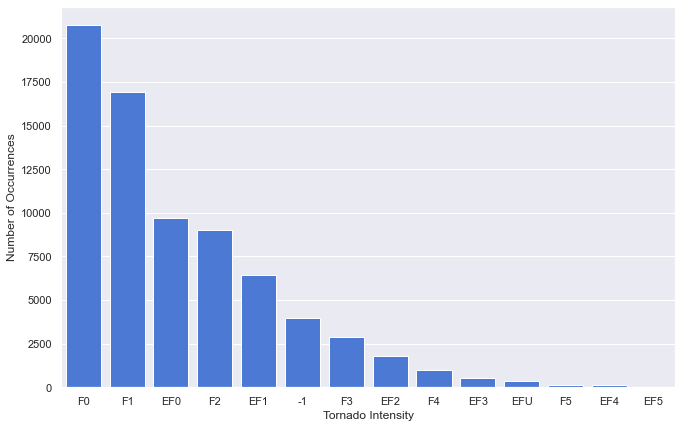

In [45]:
# Create the plot to visualize this information
ax = sb.barplot(x=intensity_counts.index, y=intensity_counts, color="#3471eb")
ax.set_xlabel("Tornado Intensity")
ax.set_ylabel("Number of Occurrences")

As expected, it looks like we have a right-skewed distribution - significantly more hurricane and tornado events that are lower strength. (This is a good thing, we don't want to see category 5 hurricanes every month...). When we move to our predictive model development, we may need to handle this class imbalance via different weighting/sampling techniques.

### Hurricane Landfall Location Inspection

Let's take a look to where these hurricanes are making landfall. Are there any anomolies within these reports? Does it seem like specific national weather zones experience more hurricanes than others?

In [46]:
# prepare the coordinates of the hurricane starting locations
hurricanes.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
BEGIN_DATE_TIME_REVAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1950-04-28 14:45:00,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-28 14:45:00,1950-04-28 14:45:00
1950-04-29 15:30:00,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-04-29 15:30:00,1950-04-29 15:30:00
1950-07-05 18:00:00,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:00:00,1950-07-05 18:00:00
1950-07-05 18:30:00,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-05 18:30:00,1950-07-05 18:30:00
1950-07-24 14:40:00,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-07-24 14:40:00,1950-07-24 14:40:00


In [47]:
hurricane_zones = hurricanes['CZ_NAME'].fillna(-1)
hurricane_zone_counts = hurricane_zones.value_counts()
hurricane_zone_counts

WASHINGTON              711
JEFFERSON               680
LINCOLN                 675
JACKSON                 634
MADISON                 525
                       ... 
DECATUR AND CLARKE        1
STORY AND BOONE           1
SHELBY AND FAYETTE        1
ATOKA AND PUSHMATAHA      1
-1                        1
Name: CZ_NAME, Length: 2061, dtype: int64

In [ ]:
pd.DataFrame({
    "Zone-Name":hurricane_zone_counts.index,
    "Count":list(hurricane_zone_counts)
}).to_csv("zone_counts.csv",index=False)

<a id='focused-data-prep'></a>
## Focused Data Preparation

Let's take some time to downselect to the features that we know we will be considering for prediction and join in any additional datasets that will provide environmental context. 

**Note 10/21**: Suggestion from class about introducing ocean temperatures as a strong predictor of intensity. Continue research into the sea surface temperature dataset. https://www.ncdc.noaa.gov/data-access/marineocean-data

**Note 10/21**: Look into converting the problem into a prediction of windspeed. This is a good point because we can reduce the number of redundant classes EF-1 vs F-1 versus category-1

In [1]:
1+1

2